# Regularization

## Why Regularize?

In an attempt to fit a good model to data, we often tend to overfit. Regularization discourages overly complex models by penalizing the loss function.

### The Bias-Variance Tradeoff

When we did Linear Regression, we briefly talked about the Bias-Variance Tradeoff.

![](http://scott.fortmann-roe.com/docs/docs/BiasVariance/biasvariance.png)

![](https://miro.medium.com/max/544/1*Y-yJiR0FzMgchPA-Fm5c1Q.jpeg)

**High bias** 

 - Systematic error in predictions (i.e. the average)
 - Bias is about the strength of assumptions the model makes
 - Underfit models tend to have high bias


**High variance**

 - The model is highly sensitive to changes in the data
 - Overfit models tend to have low bias and high variance
    
    
![](https://gblobscdn.gitbook.com/assets%2F-LvBP1svpACTB1R1x_U4%2F-LvNWUoWieQqaGmU_gl9%2F-LvNoby-llz4QzAK15nL%2Fimage.png?alt=media&token=41720ce9-bb66-4419-9bd8-640abf1fc415)

 - Underfit Models fail to capture all of the information in the data
 - Overfit models fit to the noise in the data and fail to generalize


**How would we know if our model is over or underfit?**
 - Train test split & look at the testing error
 - As model complexity increases so does the possibility for overfitting

## Ridge and Lasso

Ridge and Lasso regression are two examples of penalized estimation. Penalized estimation makes some or all of the coefficients smaller in magnitude (closer to zero). Some of the penalties have the property of performing both variable selection (setting some coefficients exactly equal to zero) and shrinking the other coefficients. 

In Ridge regression, the cost function is changed by adding a penalty term to the square of the magnitude of the coefficients. 

$$ \text{cost_function_ridge}= \sum_{i=1}^n(y_i - \hat{y})^2 = \sum_{i=1}^n(y_i - \sum_{j=1}^k(m_jx_{ij})-b)^2 + \lambda \sum_{j=1}^p m_j^2$$

Lasso regression (Least Absolute Shrinkage and Selection Operator) is very similar to Ridge regression, except that the magnitude of the coefficients are not squared in the penalty term.

$$ \text{cost_function_lasso}= \sum_{i=1}^n(y_i - \hat{y})^2 = \sum_{i=1}^n(y_i - \sum_{j=1}^k(m_jx_{ij})-b)^2 + \lambda \sum_{j=1}^p \mid m_j \mid$$

So we're penalizing large coefficients -- what are the effects/implications of that?

### Standardization before Regularization

An important step before using either Lasso or Ridge regularization is to first standardize your data such that it is all on the same scale. Regularization is based on the concept of penalizing larger coefficients, so **if you have features that are on different scales, some will get unfairly penalized**. A downside of standardization is that the value of the coefficients become less interpretable and must be transformed back to their original scale if you want to interpret how a one unit change in a feature impacts the target variable.

**Scaler documentation:**

* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html
* https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html

## Let's Code! 

Start with a regular Linear Regression.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder

# import warnings
# warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/ames_train.csv') # Ames housing data

# Drop sale detail columns 
df = df.drop(columns = ['Id', 'MoSold', 'YrSold', 'SaleType', 'SaleCondition'])

# Create X and y
y = df['SalePrice']
X = df.drop(columns=['SalePrice'], axis=1)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

### Time to Clean/Process

In [3]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1095 entries, 1023 to 1126
Data columns (total 75 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1095 non-null   int64  
 1   MSZoning       1095 non-null   object 
 2   LotFrontage    895 non-null    float64
 3   LotArea        1095 non-null   int64  
 4   Street         1095 non-null   object 
 5   Alley          70 non-null     object 
 6   LotShape       1095 non-null   object 
 7   LandContour    1095 non-null   object 
 8   Utilities      1095 non-null   object 
 9   LotConfig      1095 non-null   object 
 10  LandSlope      1095 non-null   object 
 11  Neighborhood   1095 non-null   object 
 12  Condition1     1095 non-null   object 
 13  Condition2     1095 non-null   object 
 14  BldgType       1095 non-null   object 
 15  HouseStyle     1095 non-null   object 
 16  OverallQual    1095 non-null   int64  
 17  OverallCond    1095 non-null   int64  
 18  YearB

In [4]:
# Let's check the percentage of our training data that's null per column
null_perc = X_train.isna().sum() / len(X_train)
null_perc.sort_values(ascending=False).head(20)

PoolQC          0.994521
MiscFeature     0.960731
Alley           0.936073
Fence           0.800913
FireplaceQu     0.467580
LotFrontage     0.182648
GarageQual      0.052968
GarageType      0.052968
GarageYrBlt     0.052968
GarageFinish    0.052968
GarageCond      0.052968
BsmtCond        0.024658
BsmtExposure    0.024658
BsmtFinType2    0.024658
BsmtQual        0.024658
BsmtFinType1    0.024658
MasVnrArea      0.003653
MasVnrType      0.003653
Electrical      0.000913
YearRemodAdd    0.000000
dtype: float64

In [5]:
# Dropping where nulls are more than 10% of column
null_cols = list(null_perc[null_perc > .1].index)
print(null_cols)

X_train = X_train.drop(columns=null_cols, axis=1)
X_test = X_test.drop(columns=null_cols, axis=1)

['LotFrontage', 'Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']


In [6]:
X_train.describe()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal
count,1095.000000,1095.000000,1095.000000,1095.00000,1095.000000,1095.000000,1091.000000,1095.000000,1095.000000,1095.000000,...,1037.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000
mean,57.118721,10747.046575,6.129680,5.56895,1971.107763,1984.854795,103.368469,448.178082,43.790868,568.794521,...,1978.694311,1.784475,477.539726,96.194521,49.633790,21.118721,3.918721,15.917808,3.152511,40.529680
std,42.624531,11065.878057,1.366746,1.10448,30.605697,20.732472,171.644715,457.898505,153.896464,444.865511,...,24.810675,0.733836,210.563755,130.396336,69.134174,61.315608,32.186042,56.844110,43.008391,328.354566
min,20.000000,1300.000000,1.000000,1.00000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,...,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,7589.000000,5.000000,5.00000,1953.500000,1966.000000,0.000000,0.000000,0.000000,221.500000,...,1961.000000,1.000000,349.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,50.000000,9600.000000,6.000000,5.00000,1972.000000,1994.000000,0.000000,387.000000,0.000000,474.000000,...,1980.000000,2.000000,484.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,70.000000,11700.000000,7.000000,6.00000,2001.000000,2004.000000,166.000000,724.000000,0.000000,810.500000,...,2002.000000,2.000000,576.000000,168.000000,74.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,190.000000,215245.000000,10.000000,9.00000,2010.000000,2010.000000,1378.000000,5644.000000,1127.000000,2336.000000,...,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,8300.000000


In [7]:
y_train.describe()

count      1095.000000
mean     181712.286758
std       77955.082565
min       34900.000000
25%      130000.000000
50%      165000.000000
75%      215000.000000
max      745000.000000
Name: SalePrice, dtype: float64

In [8]:
# Let's just use the continuous variables

# Grab only numeric features
cont_features = [col for col in X_train.columns if X_train[col].dtype in [np.float64, np.int64]]

X_train_cont = X_train[cont_features]
X_test_cont = X_test[cont_features]

# Impute missing values with 0 using SimpleImputer
# (most columns look like they just don't have details)
impute = SimpleImputer(strategy='constant', fill_value=0) 
X_train_imputed = impute.fit_transform(X_train_cont)
X_test_imputed = impute.transform(X_test_cont) 

# Scale the train and test data
scaler = StandardScaler()
X_train_imputed_scaled = scaler.fit_transform(X_train_imputed)
X_test_imputed_scaled = scaler.transform(X_test_imputed)

In [9]:
# # Now time for the categorical columns

# # Create X_cat which contains only the categorical variables
# features_cat = [col for col in X_train.columns if X_train[col].dtype in [np.object]]
# X_train_cat = X_train[features_cat]
# X_test_cat = X_test[features_cat]

# # Fill missing values with the string 'missing'
# X_train_cat.fillna(value='missing', inplace=True)
# X_test_cat.fillna(value='missing', inplace=True)

In [10]:
# # Exploring column percentages

# # Let's remove any column where the most common value is more than 90% of that col
# cols_to_remove = []
# for col in X_train_cat.columns:
#     col_series = X_train_cat[col].value_counts()
#     display(col_series /len(X_train_cat)) # percentages

#     if col_series[0]/len(X_train_cat) > .9:
#         print(f"You should remove {col}")
#         cols_to_remove.append(col)

In [11]:
# # Now drop those
# X_train_cat = X_train_cat.drop(columns=cols_to_remove, axis=1)
# X_test_cat = X_test_cat.drop(columns=cols_to_remove, axis=1)

In [12]:
# # OneHotEncode categorical variables
# ohe = OneHotEncoder(handle_unknown='ignore')

# X_train_ohe = ohe.fit_transform(X_train_cat)
# X_test_ohe = ohe.transform(X_test_cat)

# # Convert these columns into a DataFrame 
# ohe_col_names = ohe.get_feature_names(input_features=X_train_cat.columns)
# cat_train_df = pd.DataFrame(X_train_ohe.todense(), columns=ohe_col_names)
# cat_test_df = pd.DataFrame(X_test_ohe.todense(), columns=ohe_col_names)

In [13]:
# # Put it all back together
# X_train_all = pd.concat([pd.DataFrame(X_train_imputed_scaled), cat_train_df], axis=1)
# X_test_all = pd.concat([pd.DataFrame(X_test_imputed_scaled), cat_test_df], axis=1)

# Fitting the model
linreg = LinearRegression()
linreg.fit(X_train_imputed_scaled, y_train)

LinearRegression()

In [14]:
# Write a quick evaluation function

def evaluate(train_actual, train_predicted, test_actual, test_predicted):
    '''
    Takes in both actual and predicted values, for the train and test set
    Then prints the scores based on those values
    
    Inputs:
    -------
    train_actual - actual target values for the train set
    train_predicted - predicted target values for the train set
    test_actual - actual target values for the test set
    test_predicted - predicted target values for the test set
    '''
    print('Train R2:', r2_score(train_actual, train_predicted))
    print('Test R2:', r2_score(test_actual, test_predicted))
    print("*****")
    print('Train MSE:', mean_squared_error(train_actual, train_predicted))
    print('Test MSE:', mean_squared_error(test_actual, test_predicted))
    print("*****")
    print('Train RMSE:', mean_squared_error(train_actual, train_predicted, squared=False))
    print('Test RMSE:', mean_squared_error(test_actual, test_predicted, squared=False))

In [15]:
# Grab predictions
train_preds = linreg.predict(X_train_imputed_scaled)
test_preds = linreg.predict(X_test_imputed_scaled)

evaluate(y_train, train_preds, y_test, test_preds)

Train R2: 0.8069081146348778
Test R2: 0.8310927786436166
*****
Train MSE: 1172346787.1667256
Test MSE: 1183247286.7733538
*****
Train RMSE: 34239.550043286574
Test RMSE: 34398.361687344266


In [16]:
residuals_train = y_train - train_preds
residuals_test = y_test - test_preds

Text(0.5, 0, 'Predicted Values')

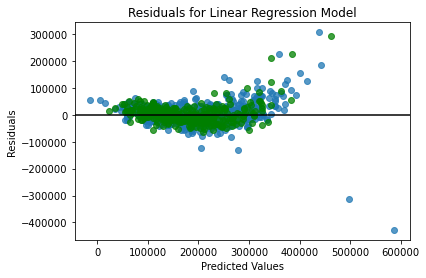

In [17]:
plt.scatter(train_preds, residuals_train, alpha=.75)
plt.scatter(test_preds, residuals_test, color='g', alpha=.75)

plt.axhline(y=0, color='black')

plt.title('Residuals for Linear Regression Model')
plt.ylabel('Residuals')
plt.xlabel('Predicted Values')

In [18]:
linreg.coef_

array([-7.71758860e+03,  4.26882649e+03,  2.43947025e+04,  4.69010930e+03,
        1.03717695e+04,  2.73934965e+03,  3.21792499e+03,  3.49536935e+16,
        1.17476903e+16,  3.39588196e+16, -3.38835509e+16, -3.37283746e+16,
       -3.84200262e+16, -4.26792005e+15,  4.59553772e+16,  6.02302723e+03,
       -2.32492692e+02,  1.88664832e+03, -9.41953695e+02, -7.28333204e+03,
       -3.30156514e+03,  8.47695446e+03,  3.21973369e+03, -6.72950034e+03,
        1.32507252e+04,  8.70085238e+02,  3.04782702e+03, -1.12286264e+03,
        2.20714546e+02,  1.43832989e+03,  3.71560727e+03, -1.16155325e+03,
       -6.75489580e+02])

In [31]:
# Explore coefficients
print(f"Intercept: {linreg.intercept_}")

coefs = pd.Series(linreg.coef_, index= X_train_cont.columns)
display(coefs.sort_values(ascending=False))

Intercept: 181728.12612814867


GrLivArea        4.595538e+16
BsmtFinSF1       3.495369e+16
BsmtUnfSF        3.395882e+16
BsmtFinSF2       1.174769e+16
OverallQual      2.439470e+04
GarageCars       1.325073e+04
YearBuilt        1.037177e+04
TotRmsAbvGrd     8.476954e+03
BsmtFullBath     6.023027e+03
OverallCond      4.690109e+03
LotArea          4.268826e+03
ScreenPorch      3.715607e+03
Fireplaces       3.219734e+03
MasVnrArea       3.217925e+03
WoodDeckSF       3.047827e+03
YearRemodAdd     2.739350e+03
FullBath         1.886648e+03
3SsnPorch        1.438330e+03
GarageArea       8.700852e+02
EnclosedPorch    2.207145e+02
BsmtHalfBath    -2.324927e+02
MiscVal         -6.754896e+02
HalfBath        -9.419537e+02
OpenPorchSF     -1.122863e+03
PoolArea        -1.161553e+03
KitchenAbvGr    -3.301565e+03
GarageYrBlt     -6.729500e+03
BedroomAbvGr    -7.283332e+03
MSSubClass      -7.717589e+03
LowQualFinSF    -4.267920e+15
1stFlrSF        -3.372837e+16
TotalBsmtSF     -3.388355e+16
2ndFlrSF        -3.842003e+16
dtype: flo

**Evaluate**

- 


## Fitting Ridge and Lasso

* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html
* https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html

### LASSO

In [20]:
from sklearn.linear_model import Lasso

lasso = Lasso() # Lasso is also known as the L1 norm 
lasso.fit(X_train_imputed_scaled, y_train)

lasso_train_preds = lasso.predict(X_train_imputed_scaled)
lasso_test_preds = lasso.predict(X_test_imputed_scaled)

evaluate(y_train, lasso_train_preds, y_test, lasso_test_preds)

Train R2: 0.8068837772699294
Test R2: 0.8310540526127361
*****
Train MSE: 1172494550.1426334
Test MSE: 1183518574.588042
*****
Train RMSE: 34241.70775739191
Test RMSE: 34402.304785988425


In [21]:
lasso_v2 = Lasso(alpha=10) # adjusting HYPERPARAMETERS -- check documentation!
lasso_v2.fit(X_train_imputed_scaled, y_train)

lasso_train_preds_v2 = lasso_v2.predict(X_train_imputed_scaled)
lasso_test_preds_v2 = lasso_v2.predict(X_test_imputed_scaled)

evaluate(y_train, lasso_train_preds_v2, y_test, lasso_test_preds_v2)

Train R2: 0.8068831254902733
Test R2: 0.8310588651469658
*****
Train MSE: 1172498507.3870533
Test MSE: 1183484861.2984385
*****
Train RMSE: 34241.76554132473
Test RMSE: 34401.8147965836


In [22]:
# Check Lasso Coefficients

print("Total number of coefficients: ", len(lasso_v2.coef_))
print("Coefficients close to zero: ", sum(abs(lasso_v2.coef_) < 10**(-10)))

Total number of coefficients:  33
Coefficients close to zero:  2


### Ridge

In [24]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=10) # Ridge is also known as the L2 norm
ridge.fit(X_train_imputed_scaled, y_train)

ridge_train_preds = ridge.predict(X_train_imputed_scaled)
ridge_test_preds = ridge.predict(X_test_imputed_scaled)

evaluate(y_train, ridge_train_preds, y_test, ridge_test_preds)

Train R2: 0.8068411586151042
Test R2: 0.8310847084101078
*****
Train MSE: 1172753306.9669466
Test MSE: 1183303821.2532074
*****
Train RMSE: 34245.48593562291
Test RMSE: 34399.18343875633


In [25]:
# Check Lasso Coefficients

print("Total number of coefficients: ", len(ridge.coef_))
print("Coefficients close to zero: ", sum(abs(ridge.coef_) < 10**(-10)))

Total number of coefficients:  33
Coefficients close to zero:  0


### Let's Discuss

- 


## Ridge & Lasso: Other benefits

### Ridge:
* We can "shrink down" prediction variables effects instead of deleting/zeroing them
* When you have features with high multicollinearity, the coefficients are automatically spread across them (you won't have redundancy)
* Since includes all features it can be computationally expensive (for many variables)

### Lasso:
* When you have a lot of variables it performs feature selection for you!
* Multicollinearity is also dealt with


### Por que no los dos??

Enter ElasticNet: https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html